## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [1]:
import os

import pandas as pd
import numpy as np
import s3fs
import zipfile
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Récupérer les données d'un challenge

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [4]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [ ]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

### Lecture des fichiers

In [5]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [6]:
#On print pour voir comment est stocké la data
#On constate : [[x, y], [x, y],...]
human_position

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

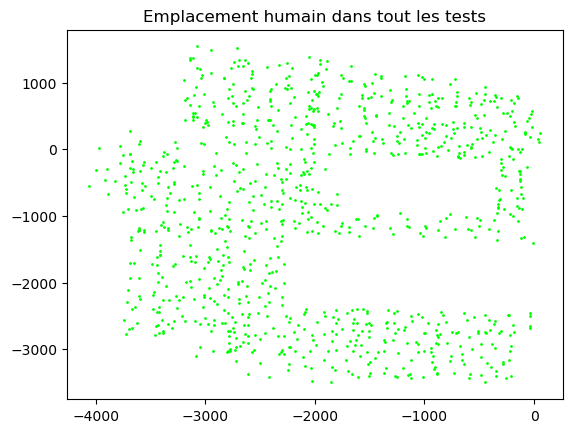

In [8]:
#Montrons avec un graph la répartition des coordonnées de l'humain
#On peut voir des carrés blancs, cela représente par exemple un canapé ou une table
#Où l'humain durant les tests ne pouvait pas se placer
plt.plot([tab_file[0] for tab_file in human_position], [tab_file2[1] for tab_file2 in human_position], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()

In [124]:
#On récupère les données RIR : Room Impulse Response
rir_data = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rir_data

array([[[ 9.07240337e-06,  1.71257434e-05,  1.22597794e-05, ...,
          8.86178623e-06,  1.40686043e-05,  1.06616626e-05],
        [-8.23853679e-06, -8.23373648e-06, -8.74563466e-06, ...,
          2.87394778e-06, -8.90485808e-06, -3.52464713e-06],
        [ 6.62780906e-07, -1.40201587e-06,  1.83228190e-06, ...,
         -1.06218545e-06,  8.53497477e-06,  2.28155182e-06],
        [ 8.11119719e-07, -2.47451499e-06,  5.82140547e-06, ...,
          7.73804004e-06,  2.29692650e-05,  1.10566034e-05]],

       [[ 1.64466037e-05,  1.53698293e-05,  1.91599720e-05, ...,
          1.76548729e-05,  1.70955263e-05,  1.41169767e-05],
        [ 1.05826217e-07,  9.13145777e-06,  1.76140716e-07, ...,
          1.21369967e-05,  1.55958387e-05,  1.23088676e-05],
        [ 7.06836090e-06,  3.26818258e-06,  7.15508941e-06, ...,
          4.64980394e-06,  8.96262554e-06,  6.55734584e-06],
        [-3.18089551e-05, -8.93297238e-06, -2.51026504e-05, ...,
         -7.02741545e-07,  1.34268867e-05,  3.24307

In [162]:
print(rir_data.shape[2])
num_rows = rir_data.shape[2]
thirty_percent_index = int(0.3 * num_rows)
rir = rir_data[:, :, :thirty_percent_index]
print(rir_first_30_percent.shape)

667200
(1000, 4, 200160)


In [134]:
#Regardons plus en détail la data rir
len(rir[0])
print(" ")
len(rir[0][0])

print(rir[0])
print(len(rir[0][0]))

 
[[ 9.0724034e-06  1.7125743e-05  1.2259779e-05 ... -3.2670541e-06
  -1.1854075e-06 -1.1625249e-06]
 [-8.2385368e-06 -8.2337365e-06 -8.7456347e-06 ...  1.0793881e-05
   2.9975918e-06  7.2529206e-06]
 [ 6.6278091e-07 -1.4020159e-06  1.8322819e-06 ... -7.8843195e-06
  -3.8899555e-07 -9.0055655e-06]
 [ 8.1111972e-07 -2.4745150e-06  5.8214055e-06 ... -4.4172843e-06
  -1.7114508e-05 -4.5313277e-06]]
200160


Le block juste en dessous est la méthode RMS. Bien qu'elle soit utilisable pour le KNN et a de meilleurs résultats
(très léger, on a 108cm de Moyenne des distances euclidiennes, contre 133cm par SoundCam) que le KNN du rapport de SoundCam.
La méthode utilisant PCA (juste en dessous de RMS) est bien meilleure, donc nous allons l'utiliser à la place de RMS

In [74]:
#On applique la méthode RMS, pour Root Mean Square
#Qui permet de donner la moyenne de l'amplitude des sons de rir en 1 seule donnée
#RMS_levels = np.sqrt(np.mean(rir**2, axis=2))
#print(RMS_levels)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]


In [135]:
from sklearn.decomposition import PCA

#On applique la méthode PCA sur RIR
#Le but est de projeter des données multidimensionnelles dans un espace de dimensions plus petites 
#Tout en conservant autant d'information que possible
X_reshaped = rir.reshape(1000, -1)
pca = PCA(n_components=100)
RMS_levels = pca.fit_transform(X_reshaped)
print(RMS_levels)

[[ 7.7373907e-02 -2.5836578e-01  3.6190784e-01 ...  4.8711547e-03
  -1.1933287e-02 -9.2583960e-03]
 [ 7.2115824e-02 -2.7060294e-01  3.2960856e-01 ...  6.8187444e-03
  -5.0965049e-03 -4.4769216e-03]
 [ 6.0272053e-02 -2.5213981e-01  3.5522437e-01 ...  1.2202809e-02
   7.9101359e-04  1.5571493e-02]
 ...
 [-2.4986386e-01  4.5532045e-01  1.1053603e-01 ...  2.6842882e-04
  -3.7983942e-03  4.7946954e-03]
 [-2.4893507e-01  4.3469578e-01  9.0123042e-02 ...  1.4155525e-02
  -6.5073157e-03  1.5845358e-02]
 [-3.9340444e-02  3.8739446e-01  3.1162987e-02 ...  1.1576671e-03
   3.4167223e-02 -2.2269918e-02]]


In [136]:
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)
print(normalized_RMS)

[[ 0.2237152  -1.036795    1.7458606  ...  0.4033363  -0.9962928
  -0.7812265 ]
 [ 0.20851223 -1.0859015   1.5900472  ...  0.5645985  -0.42549992
  -0.37776417]
 [ 0.17426775 -1.0118108   1.7136192  ...  1.0104039   0.06604036
   1.3139277 ]
 ...
 [-0.7224435   1.8271539   0.53323114 ...  0.02222643 -0.31712258
   0.40457794]
 [-0.71975803  1.7443893   0.4347579  ...  1.1720905  -0.54328644
   1.3370365 ]
 [-0.11374678  1.554574    0.15033183 ...  0.09585617  2.852571
  -1.879143  ]]


In [137]:
#On divise les données en données d'entrainement pour notre Knn
#Et en donnée de test pour tester notre entrainement de Knn pour voir si il arrive bien à prédire
#On prend 80% d'entrainement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(normalized_RMS, human_position, test_size=0.2, random_state=42)

In [150]:
#On initialise notre Knn en prenant en compte 3 voisins
k = 2
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [152]:
#Avec notre Knn, on essaye de prédire la position de l'humain sur toutes les données de test
#predicted_position = knn.predict(query_RMS)
predicted_position = knn.predict(X_test)
print("Predicted human position:", predicted_position)

Predicted human position: [[-1168.69215493   255.63480137]
 [-2292.31961122 -1072.81142547]
 [ -980.34185285 -1063.45965137]
 [-2649.1539304  -2731.31926784]
 [-1820.30636699 -2513.99074361]
 [-2591.89543384   835.03725652]
 [-1460.86847285 -2802.52654246]
 [ -842.97995279   334.25794512]
 [-1186.45626027 -3358.47536009]
 [ -525.49929201   672.04601816]
 [  -22.82846019   555.77742823]
 [-2656.76448765 -1784.18112768]
 [-1373.68485576 -2961.78476458]
 [-1504.29506432 -2713.53513479]
 [ -410.79394498 -2729.3210361 ]
 [-3345.23484112  -220.84579206]
 [-1591.38292471   -61.26197841]
 [-1577.08442138   265.1350852 ]
 [-2943.82781423 -2010.15073805]
 [-3338.14103345 -1963.4504829 ]
 [-3438.25502271 -2502.40453176]
 [ -258.34129743  -241.85154326]
 [-3129.0504862   -393.48810473]
 [-1329.62040441   662.9707044 ]
 [-1006.2303054  -1197.52919673]
 [-2528.28893226 -2491.88785502]
 [-2085.74783644   961.40147521]
 [-1570.36282425 -3025.44937945]
 [-3590.97056687   -83.23732096]
 [ -727.43254992 

In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, predicted_position)
mae = mean_absolute_error(y_test, predicted_position)
r2 = r2_score(y_test, predicted_position)

print("Test MSE : ", mse)
print("Test MAE : ", mae)
print("Test R2 : ", r2)

Test MSE :  334811.37485652405
Test MAE :  341.05608606973493
Test R2 :  0.7716940448430469


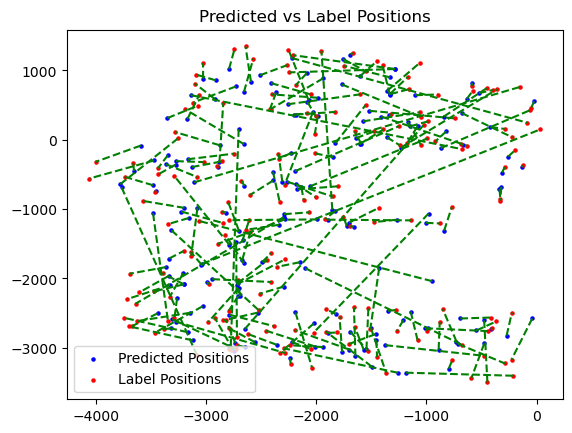

In [154]:
#On montre un graph représentant la chambre, avec :
# - En point bleu, les positions humaines que notre Knn à prédit
# - En point rouge, les vraies positions des humains dans chaque test
# - Les lignes vertes connectent la valeur prédite à son label
plt.scatter(predicted_position[:, 0], predicted_position[:, 1], color='blue', label='Predicted Positions', s=5)
plt.scatter(y_test[:, 0], y_test[:, 1], color='red', label='Label Positions', s=5)
for i in range(len(predicted_position)):
    plt.plot([predicted_position[i][0], y_test[i][0]], [predicted_position[i][1], y_test[i][1]], color='green', linestyle='--')
plt.title('Predicted vs Label Positions')
plt.legend()
plt.show()

In [155]:
#Donne le pourcentage de bon résultat en fonction d'une intervalle
#L'intervalle définit le degré d'acceptation pour dire si la coordonée prédite est la même que celle du test
#Par exemple, avec un intervalle de 500, on accepte que la coordonée puisse être à 50cm d'écart maximum de celle initiale
good_result = 0
intervalle = 500
for i in range(0, len(predicted_position)):
    if predicted_position[i][0] > y_test[i][0] - intervalle and predicted_position[i][0] < y_test[i][0] + intervalle:
        if predicted_position[i][1] > y_test[i][1] - intervalle and predicted_position[i][1] < y_test[i][1] + intervalle:
            good_result += 1

print("Le pourcentage de bonnes prédictions est de : " + str(good_result / len(predicted_position)))

Le pourcentage de bonnes prédictions est de : 0.71


In [156]:
#Donne la distance Euclidienne moyenne entre les labels et les valeurs prédite en mm
def euclidean_distance(predicted_position, y_test):
    diff = y_test - predicted_position
    dist = np.linalg.norm(diff, axis=1)
    return dist

disst = euclidean_distance(y_test, predicted_position)
mean_dist = np.mean(disst)

print(mean_dist)

542.2598085775882


Ici, avec PCA, on a une moyenne de distance euclidienne de 56,6cm.
Comme on le voit sur le document de SoundCam, pour la chambre LivingRoom, ils ont une distance moyenne de 170cm
Notre modèle est donc bien plus efficace que le leurs